## Generation of visual panoramas to be tested for head direction stability
Run in unityvr virtual environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle
from scipy.signal import convolve2d
from pathlib import Path
from os.path import sep
import scipy as sp
import imageio
import pandas as pd
import json

np.random.seed(seed=3)
%config Completer.use_jedi = False  #magic to fix autocomplete issue
%matplotlib inline

from stimGen import generateSingleSpotPan, plotPanorama, plotPanoramaStretch, createMovie

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

### Visibility range of the screen
#### (a) Visibility above the horizon line
This visibility range is limited by either the fly holder (pyramid) or the screen height. 
If the screen is limited, the angle it spans depends on the screen distance  which may vary along the azimuth. We will consider only the extreme values, i.e. the minimum and maximum screen distances. For the pentagonal screen that's r_min at the center of the faces and r_max at the corners. 

In [2]:
screenMinDist = 4.0 #cm (r_min in Fig1 S1)
screenMaxDist = 5.5 #cm (r_max in Fig1 S1)

topScreenHeight = 2.5 #cm
bottomScreenHeight = 7 #cm

alpha_rmin = (180/np.pi) * np.arctan( topScreenHeight / screenMinDist)
alpha_rmax = (180/np.pi) * np.arctan( topScreenHeight / screenMaxDist)

print("The screen spans an angle from {} to {} above the horizon line.".format(alpha_rmax, alpha_rmin))

The screen spans an angle from 24.443954780416536 to 32.005383208083494 above the horizon line.


#### (b) Visibility below the horizon line
This visibility range is limited by the ball surface (unless the screen doesn't extend much below the fly). Set `no_ball` to be true if screen limited.

In [3]:
no_ball = False

In [4]:
if not no_ball:
    ballRad = 4.65 # treadmill ball radius [mm]
    flyEyeAboveBall = 1 # height of eye above ball surface [mm]
    print('Angle visible below horizon line:',90-(180/np.pi)*np.arcsin(ballRad/(flyEyeAboveBall+ballRad)))
else:
    beta_rmin = (180/np.pi) * np.arctan( bottomScreenHeight / screenMinDist)
    beta_rmax = (180/np.pi) * np.arctan( bottomScreenHeight / screenMaxDist)
    print("The screen spans an angle from {} to {} below the horizon line.".format(beta_rmax, beta_rmin))

Angle visible below horizon line: 34.61286464893424


### Determine appropriate size for the texture
Choose which angle should be spanned. The texture will be sized to be displayed such that it spans the full size at the closest points on the  screen (r_min). Thus, the texture should be displayed on a cylinder with radius r_min.

In [5]:
RFmapCylinder = True

In [6]:
setalpha = alpha_rmin*(np.pi/180) if not no_ball else np.max([beta_rmin,alpha_rmin])*(np.pi/180)
if RFmapCylinder:
    height_cm = 7
else:
    height_cm = np.round(np.tan(setalpha) * screenMinDist, 2) * 2
# Values to set in unity scene:
print('Cylinder height: {} cm, Cylinder radius: {} cm'.format(height_cm/2, screenMinDist))

Cylinder height: 3.5 cm, Cylinder radius: 4.0 cm


In [7]:
singleScreenResolution = [720,480] # pixels # long axis of screen is elevation and short axis is azimuth

## calculating pixel/cm based on the minimal allowed resolution so that the full resolution of the panorama can be used
##  TODO: check if this is correct (calculation based on circle to line projection)
pt_per_cm = np.max([1/(((2*np.sqrt(screenMaxDist**2-screenMinDist**2))/singleScreenResolution[1])*(1/(1+(screenMaxDist/screenMinDist)**2))), 
                    singleScreenResolution[0]/(topScreenHeight+bottomScreenHeight)])

panHeight_px = int(height_cm * pt_per_cm)
panWidth_px = int(2*np.pi*screenMinDist*pt_per_cm)

maxBit = 255 #assuming 8bit image depth
print("pixels along elevation:",panHeight_px)
print("pixels along azimuth:",panWidth_px)

pixels along elevation: 1286
pixels along azimuth: 4618


## Step Gratings

### Create 1D Pattern

In [8]:
equal = True #white and black bars same size

In [9]:
spatialFreq = 1/5 #dark bars/deg
if equal:
    barSizeAng = 1/spatialFreq
else:
    barSizeAng = 20 #aim for x deg dark bars

In [10]:
barRad = int(panWidth_px * 0.5 * (barSizeAng/360))
whiteBar = rectangle(panHeight_px, barRad)

In [11]:
oneD = np.zeros(panWidth_px)
oneD[np.linspace(0,panWidth_px-1,int(round(spatialFreq*360))).round().astype('int')] = maxBit
kernel = np.ones(barRad)
oneDGrating = sp.signal.convolve(oneD, kernel, mode='same')

## Convert to 2D and Rotate

In [12]:
rotAngle = 0 #deg, right handed convention
dpiVal = 300

In [13]:
pan = np.zeros((panWidth_px,panHeight_px),dtype=np.uint8)
for i in range(pan.shape[1]):
    pan[:,i] = (255-oneDGrating/1.25)

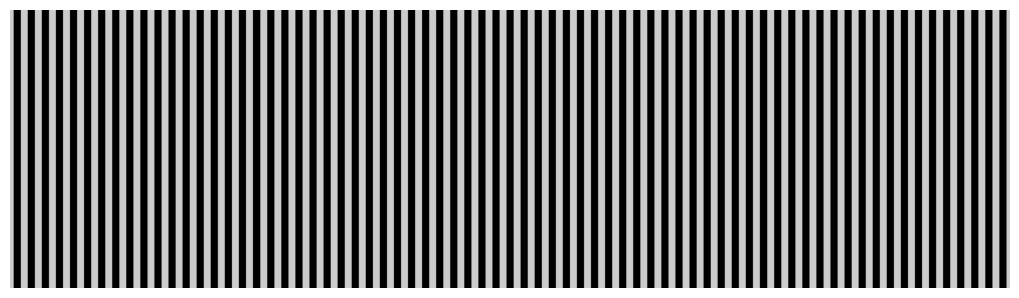

In [14]:
twoDGrating = sp.ndimage.rotate(pan,rotAngle,reshape=False,mode='grid-wrap')
fig = plotPanorama(twoDGrating,panHeight_px,panWidth_px, maxBit)
fig.savefig("panoramas"+sep+f"OLGratingStimuli-{barSizeAng}deg.png", dpi = dpiVal)

In [15]:
import pandas as pd
from scipy.optimize import minimize
import scipy as sp

Dir = 'screenMeasurements/' #"/Volumes/jayaramanlab/Shivam/" #connect to dm11
rig = "Hannah" #"Shivam"#

if rig == "Shivam":
    file2 = rig+"Rig_mean_brightness_level_6.csv"
else:
    file2 = rig+"Rig_mean_brightness.csv"
    
file = rig+"Rig_lookup_table_transformed_brightness.csv"

lookupDf = pd.read_csv(Dir+file)
mean_brightness = pd.read_csv(Dir+file2)

In [16]:
def rescale(img):
    x = img.flatten()
    y = np.array(lookupDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

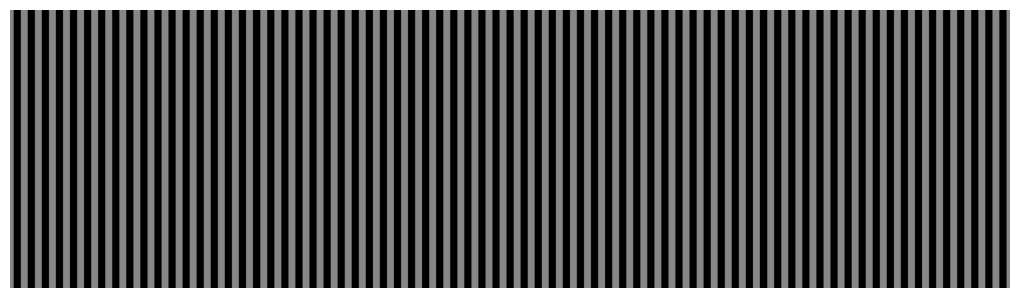

In [17]:
RFpans = [twoDGrating]
panName = [f"OLGratingStimuli-{barSizeAng}deg"]
for i,RFpan in enumerate(RFpans):
    fig = plotPanorama(rescale(RFpan),panHeight_px,panWidth_px, maxBit)
    fig.savefig("panoramas"+sep+"reshaped"+sep+panName[i]+"_reshaped_{}Rig.png".format(rig),dpi = dpiVal)